<a href="https://colab.research.google.com/github/beatlesatani/coding_september/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#use this website as a refenrece
#https://qiita.com/omiita/items/1735c1d048fe5f611f80
#https://www.youtube.com/watch?v=pXGBHV3y8rs&list=PLeo1K3hjS3uu7CxAacxVndI4bE_o3BDtO&index=12

In [2]:
# the dataset,train.csv and test.csv came from https://www.kaggle.com/datasets/abhi8923shriv/sentiment-analysis-dataset

In [ ]:
!pip install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 16.7 MB/s eta 0:00:00


In [ ]:
pip install "tf-models-official==2.13.*"

In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
#setup the dataset
test = 'https://raw.githubusercontent.com/beatlesatani/coding_september/main/test.csv'
train = "https://raw.githubusercontent.com/beatlesatani/coding_september/main/train.csv"
test = pd.read_csv(test,encoding='unicode_escape')
train = pd.read_csv(train,encoding='unicode_escape')

In [ ]:
# remove unusuful columns
test = test.iloc[:,1:3]
train = train.iloc[:, [1,3]]

In [ ]:
#check the insull values of train dataframe
train.isnull().sum()
#only one text is missing, so drop that low that incluse null cell
train = train.dropna()
#re-check null values
train.isnull().sum()

In [ ]:
#check the insull values of train dataframe
test.isnull().sum()

In [ ]:
#afeter checking original csv file, all raws after 3533 is null
test = test.dropna()
#re-check null values
test.isnull().sum()

In [ ]:
#check the label imbalance
train['sentiment'].value_counts(normalize=True)


In [ ]:
test['sentiment'].value_counts(normalize=True)

In [ ]:
#graph
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x='sentiment', data=train, ax=axes[0],saturation = 0.75)
axes[0].set_title('Train Data')

# Plot the countplot for 'sentiment' in the 'test' DataFrame
sns.countplot(x='sentiment', data=test, ax=axes[1])
axes[1].set_title('Test Data')

# Adjust layout for better visibility
plt.tight_layout()

# Show the plots
plt.show()


## we can conclude the labels are not inbalanced

## convert each sentiment into numerical value
### neagtive → -1
### neutral → 0
### postive → 1

In [ ]:
#before working to the model, convert labels into numerical number
train['label'] = train['sentiment'].apply(lambda x: -1 if x== 'negative' else(0 if x == 'neutral' else 1))
train = train.drop('sentiment',axis = 1)
test['label'] = test['sentiment'].apply(lambda x: -1 if x== 'negative' else(0 if x == 'neutral' else 1))
test = test.drop('sentiment',axis = 1)

In [ ]:
train['label'].value_counts(normalize=True) # got same ratio before converting

In [ ]:
train

In [ ]:
#split the dataset
X_train = train['text']
y_train = train['label']
X_test = test['text']
y_test = test['label']

## data preprocessing part


> Here, I use BERT not word2vec for fine-tuning cause BERT can cosider context.



> Whole Process of the Model


1.   text is imported in the InputLayer
2.   In the BERT layer, texts are converted into the vector so that model can retrieve it
3.  In the neural network layer, some parameter tuning is done






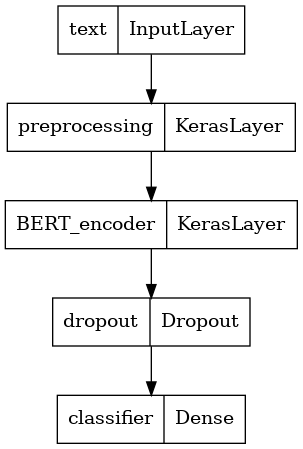



In [ ]:
bert_preprocess= hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder =  hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [ ]:

#binary classification ではないから注意
def build_classifier_model():
  # Bert layers
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessed_text = bert_preprocess(text_input)
  outputs = bert_encoder(preprocessed_text)  #here converted into the vector

  # Neural network layers
  l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
  l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

  # Use inputs and outputs to construct a final model
  model = tf.keras.Model(inputs=[text_input], outputs = [l])
  return model

In [ ]:
classifier_model = build_classifier_model()

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
#ここらへんのチューニング　さらに勉強する必要あり

In [ ]:
METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

classifier_model.compile(optimizer='adam',
              loss='CategoricalCrossentropy',
              metrics=METRICS)


In [ ]:
classifier_model.fit(X_train,y_train,epochs = 5)

In [ ]:
#more parameter tuting section to improve accuracy